# Stress level voorspellen

### Imports

In [20]:
import kagglehub
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

### Data importeren

In [2]:


# Download latest version
path = kagglehub.dataset_download("amar5693/screen-time-sleep-and-stress-analysis-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))


Path to dataset files: C:\Users\Nima\.cache\kagglehub\datasets\amar5693\screen-time-sleep-and-stress-analysis-dataset\versions\1
['Smartphone_Usage_Productivity_Dataset_50000.csv']


In [3]:
file_path = os.path.join(path, "Smartphone_Usage_Productivity_Dataset_50000.csv")


df = pd.read_csv(file_path)
df.head(
)


,User_ID,Age,Gender,Occupation,Device_Type,Daily_Phone_Hours,Social_Media_Hours,Work_Productivity_Score,Sleep_Hours,Stress_Level,App_Usage_Count,Caffeine_Intake_Cups,Weekend_Screen_Time_Hours
0,U1,58,Male,Professional,Android,1.3,6.7,6,8.8,4,42,1,8.7
1,U2,25,Male,Professional,Android,1.2,1.5,5,6.4,1,51,3,5.1
2,U3,19,Male,Student,iOS,5.3,5.7,5,9.0,4,14,5,6.3
3,U4,35,Female,Business Owner,iOS,5.8,2.5,2,5.7,3,36,6,12.8
4,U5,33,Male,Freelancer,Android,7.9,1.3,4,5.7,3,37,5,9.9


### Data controleren

#### Basis informatie

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   User_ID                    50000 non-null  object 
 1   Age                        50000 non-null  int64  
 2   Gender                     50000 non-null  object 
 3   Occupation                 50000 non-null  object 
 4   Device_Type                50000 non-null  object 
 5   Daily_Phone_Hours          50000 non-null  float64
 6   Social_Media_Hours         50000 non-null  float64
 7   Work_Productivity_Score    50000 non-null  int64  
 8   Sleep_Hours                50000 non-null  float64
 9   Stress_Level               50000 non-null  int64  
 10  App_Usage_Count            50000 non-null  int64  
 11  Caffeine_Intake_Cups       50000 non-null  int64  
 12  Weekend_Screen_Time_Hours  50000 non-null  float64
dtypes: float64(4), int64(5), object(4)
memory usag

None

#### Missende waardes

In [5]:
df.isnull().sum()

#crazy

User_ID                      0
Age                          0
Gender                       0
Occupation                   0
Device_Type                  0
Daily_Phone_Hours            0
Social_Media_Hours           0
Work_Productivity_Score      0
Sleep_Hours                  0
Stress_Level                 0
App_Usage_Count              0
Caffeine_Intake_Cups         0
Weekend_Screen_Time_Hours    0
dtype: int64

### Feauture engineering

In [6]:
### Numerieke waarde

In [7]:
# Totaal screentime
df["Total_Screen_Time"] = (
    df["Daily_Phone_Hours"] +
    df["Social_Media_Hours"] +
    df["Weekend_Screen_Time_Hours"]
)


# Hoeveelheid caffeine per geslaapte uur
df["Caffeine_per_Sleep"] = (
    df["Caffeine_Intake_Cups"] / df["Sleep_Hours"] + 0.1)

# Digital Fatigue Index
df['Digital_Fatigue'] = np.log1p(df['App_Usage_Count']) * df['Total_Screen_Time']


# Efficiency Score 
df['Productivity_Per_Caffeine'] = df['Work_Productivity_Score'] / (df['Caffeine_Intake_Cups'] + 1)

# Stress load index
df["Stress_Load_Index"] = (
    df["Total_Screen_Time"] * 
    (df["Caffeine_Intake_Cups"] + 1) / 
    (df["Sleep_Hours"] + 1)
)

# Dopamine overload
df["Dopamine_Overload"] = (
    df["Social_Media_Hours"] *
    np.log1p(df["App_Usage_Count"])
)
# Hoevaak iemand van app switch
df['App_Switch_Intensity'] = df['App_Usage_Count'] / (df['Daily_Phone_Hours'] + 0.1)

# Zitten ze vooral op social media of niet?
df['Social_Media_Dominance'] = df['Social_Media_Hours'] / (df['Daily_Phone_Hours'] + 0.1)

# Slaap je meer dan schermtijd
df['Sleep_Screen_Balance'] = df['Sleep_Hours'] / (df['Daily_Phone_Hours'] + 0.1)

# Effectiviteit op telefoon
df['Digital_Efficiency_Score'] = df['Work_Productivity_Score'] / (df['Total_Screen_Time'] + 0.1)

# Weekend vs weekgedrag
df['Weekend_Expansion_Factor'] = df['Weekend_Screen_Time_Hours'] / (df['Daily_Phone_Hours'] + 0.1)

# Screen_Sleep_Imbalance
df["Screen_Sleep_Imbalance"] = (df["Total_Screen_Time"] / (df["Sleep_Hours"] + 0.1))

# Social media burnout
df["Social_Burnout"] = (df["Social_Media_Hours"] / (df["Sleep_Hours"] + 0.1))

# Work pressure
df["Work_Pressure"] = (df["Work_Productivity_Score"] / df["Sleep_Hours"] + 0.1)

#Stress level category
def categorize_stress(level):
    if level <= 3:
        return 'Low'
    elif level <= 7:
        return 'Medium'
    else:
        return 'High'

df['Stress_Category'] = df['Stress_Level'].apply(categorize_stress)





In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   User_ID                    50000 non-null  object 
 1   Age                        50000 non-null  int64  
 2   Gender                     50000 non-null  object 
 3   Occupation                 50000 non-null  object 
 4   Device_Type                50000 non-null  object 
 5   Daily_Phone_Hours          50000 non-null  float64
 6   Social_Media_Hours         50000 non-null  float64
 7   Work_Productivity_Score    50000 non-null  int64  
 8   Sleep_Hours                50000 non-null  float64
 9   Stress_Level               50000 non-null  int64  
 10  App_Usage_Count            50000 non-null  int64  
 11  Caffeine_Intake_Cups       50000 non-null  int64  
 12  Weekend_Screen_Time_Hours  50000 non-null  float64
 13  Total_Screen_Time          50000 non-null  flo

### Objectieve waarde

In [9]:
# Maak een categorische kolom van leeftijd
bins = [0, 25, 45, 65, 100]
labels = ['Student/Junior', 'Work-Life Balance Era', 'Senior/Manager', 'Retired']
df['Life_Stage'] = pd.cut(df['Age'], bins=bins, labels=labels)

def create_lifestyle_tag(row):
    # We definiëren profielen op basis van drempelwaarden 
    if row['Sleep_Hours'] < 6.5 and row['Work_Productivity_Score'] > 5.5:
        return 'Burnout_Candidate'
    elif row['Social_Media_Hours'] > 4.3:
        return 'Doomscroller'
    elif row['Caffeine_Intake_Cups'] > 3 and row['Sleep_Hours'] > 6.5:
        return 'Caffeinated_Sleeper'
    elif row['Daily_Phone_Hours'] < 3.8:
        return 'Digital_Minimalist'
    else:
        return 'Average_User'

df['User_Category'] = df.apply(create_lifestyle_tag, axis=1)

In [10]:
df.head()

,User_ID,Age,Gender,Occupation,Device_Type,Daily_Phone_Hours,Social_Media_Hours,Work_Productivity_Score,Sleep_Hours,Stress_Level,...,Social_Media_Dominance,Sleep_Screen_Balance,Digital_Efficiency_Score,Weekend_Expansion_Factor,Screen_Sleep_Imbalance,Social_Burnout,Work_Pressure,Stress_Category,Life_Stage,User_Category
0,U1,58,Male,Professional,Android,1.3,6.7,6,8.8,4,...,4.785714,6.285714,0.357143,6.214286,1.876404,0.752809,0.781818,Medium,Senior/Manager,Doomscroller
1,U2,25,Male,Professional,Android,1.2,1.5,5,6.4,1,...,1.153846,4.923077,0.632911,3.923077,1.200000,0.230769,0.881250,Low,Student/Junior,Digital_Minimalist
2,U3,19,Male,Student,iOS,5.3,5.7,5,9.0,4,...,1.055556,1.666667,0.287356,1.166667,1.901099,0.626374,0.655556,Medium,Student/Junior,Doomscroller
3,U4,35,Female,Business Owner,iOS,5.8,2.5,2,5.7,3,...,0.423729,0.966102,0.094340,2.169492,3.637931,0.431034,0.450877,Low,Work-Life Balance Era,Average_User
4,U5,33,Male,Freelancer,Android,7.9,1.3,4,5.7,3,...,0.162500,0.712500,0.208333,1.237500,3.293103,0.224138,0.801754,Low,Work-Life Balance Era,Average_User


## EDA

In [11]:
print("Statistiek van de df")
round(df.describe(), 2)

Statistiek van de df


,Age,Daily_Phone_Hours,Social_Media_Hours,Work_Productivity_Score,Sleep_Hours,Stress_Level,App_Usage_Count,Caffeine_Intake_Cups,Weekend_Screen_Time_Hours,Total_Screen_Time,...,Stress_Load_Index,Dopamine_Overload,App_Switch_Intensity,Social_Media_Dominance,Sleep_Screen_Balance,Digital_Efficiency_Score,Weekend_Expansion_Factor,Screen_Sleep_Imbalance,Social_Burnout,Work_Pressure
count,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.0,50000.00,50000.00,...,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00
mean,39.03,6.51,4.27,5.50,6.50,5.50,32.44,3.0,8.01,18.78,...,10.45,14.32,7.04,0.93,1.41,0.32,1.74,3.00,0.68,0.99
std,12.41,3.17,2.16,2.87,1.45,2.87,16.12,2.0,3.46,5.15,...,6.61,7.83,6.92,0.93,1.15,0.21,1.64,1.10,0.39,0.52
min,18.00,1.00,0.50,1.00,4.00,1.00,5.00,0.0,2.00,3.90,...,0.48,0.90,0.41,0.04,0.33,0.03,0.17,0.44,0.05,0.21
25%,28.00,3.80,2.40,3.00,5.20,3.00,18.00,1.0,5.00,15.10,...,5.15,7.70,2.79,0.36,0.69,0.16,0.74,2.20,0.36,0.56
50%,39.00,6.50,4.30,5.50,6.50,6.00,32.00,3.0,8.00,18.80,...,9.33,13.82,4.92,0.64,0.98,0.29,1.20,2.85,0.65,0.95
75%,50.00,9.20,6.10,8.00,7.80,8.00,46.00,5.0,11.00,22.40,...,14.45,20.34,8.39,1.11,1.68,0.43,2.08,3.65,0.94,1.33
max,60.00,12.00,8.00,10.00,9.00,10.00,60.00,6.0,14.00,33.70,...,44.94,32.89,54.55,7.27,8.18,2.44,12.64,7.85,1.95,2.60


In [12]:
print("Unieke waardes per col:")
for col in df.columns:
    print(col, ":", df[col].nunique())

Unieke waardes per col:
User_ID : 50000
Age : 43
Gender : 3
Occupation : 4
Device_Type : 2
Daily_Phone_Hours : 111
Social_Media_Hours : 76
Work_Productivity_Score : 10
Sleep_Hours : 51
Stress_Level : 10
App_Usage_Count : 56
Caffeine_Intake_Cups : 7
Weekend_Screen_Time_Hours : 121
Total_Screen_Time : 658
Caffeine_per_Sleep : 263
Digital_Fatigue : 16836
Productivity_Per_Caffeine : 47
Stress_Load_Index : 29815
Dopamine_Overload : 4144
App_Switch_Intensity : 4438
Social_Media_Dominance : 6128
Sleep_Screen_Balance : 4790
Digital_Efficiency_Score : 3371
Weekend_Expansion_Factor : 9811
Screen_Sleep_Imbalance : 13813
Social_Burnout : 3273
Work_Pressure : 426
Stress_Category : 3
Life_Stage : 3
User_Category : 5


In [13]:
groep_stress = df.groupby("Occupation")["Stress_Level"].mean().sort_values(ascending=False)
groep_stress

Occupation
Student           5.545418
Professional      5.504632
Freelancer        5.493344
Business Owner    5.474356
Name: Stress_Level, dtype: float64

In [14]:
# Check of de categorieën verschillende stressniveaus hebben
print(df.groupby('User_Category')['Stress_Level'].mean().sort_values())

User_Category
Doomscroller           5.491498
Average_User           5.501045
Caffeinated_Sleeper    5.509970
Digital_Minimalist     5.510613
Burnout_Candidate      5.522927
Name: Stress_Level, dtype: float64


In [15]:
df.corr(numeric_only=True)["Stress_Level"].sort_values(ascending=False)


Stress_Level                 1.000000
Work_Productivity_Score      0.009786
Digital_Efficiency_Score     0.007941
Productivity_Per_Caffeine    0.007414
Work_Pressure                0.006710
Weekend_Expansion_Factor     0.006266
Sleep_Screen_Balance         0.004787
Sleep_Hours                  0.004691
Social_Media_Dominance       0.003507
Weekend_Screen_Time_Hours    0.002671
Caffeine_Intake_Cups         0.001718
Caffeine_per_Sleep           0.000980
Digital_Fatigue              0.000523
App_Switch_Intensity        -0.000627
Total_Screen_Time           -0.001049
App_Usage_Count             -0.001272
Stress_Load_Index           -0.001395
Age                         -0.001512
Dopamine_Overload           -0.001632
Social_Media_Hours          -0.002721
Daily_Phone_Hours           -0.002762
Social_Burnout              -0.004600
Screen_Sleep_Imbalance      -0.004681
Name: Stress_Level, dtype: float64

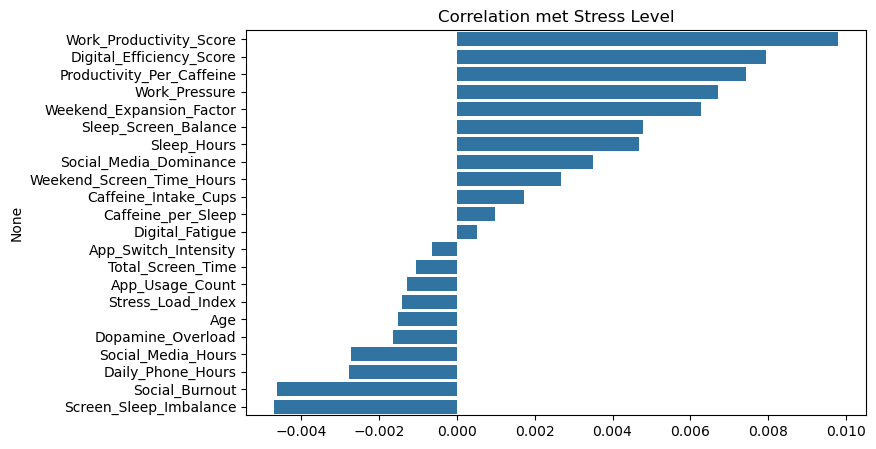

In [16]:
plt.figure(figsize=(8,5))
corr = df.corr(numeric_only=True)["Stress_Level"].sort_values(ascending=False).drop(["Stress_Level"])

sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation met Stress Level")
plt.show()


Text(0.5, 1.0, 'Correlation Matrix of Health and Usage Metrics')

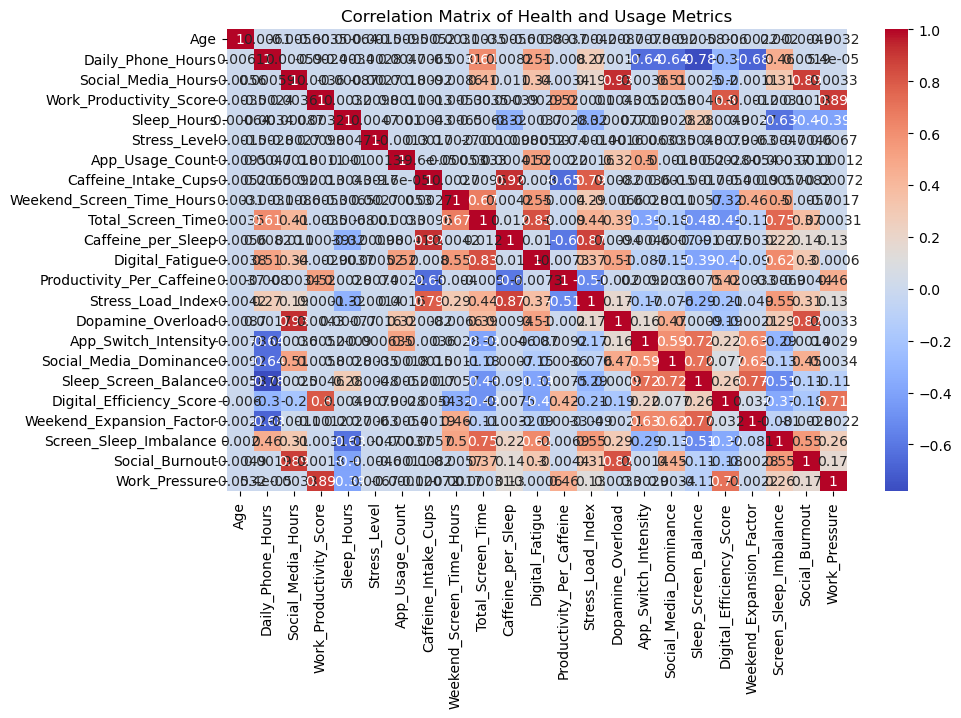

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Health and Usage Metrics')



### Welke features beinvloeden de stress het meest?

In [21]:
# Targets en Features voorbereiden
X = df.drop(['Stress_Level', 'Stress_Category', 'User_ID'], axis=1, errors='ignore')
X = pd.get_dummies(X, drop_first=True)
y = df['Stress_Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# We maken een dictionary met de modellen die we willen testen
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "SVM": SVC(kernel='rbf', class_weight='balanced', probability=True)
}

# Om XGBoost te laten werken moeten we de labels (High, Medium, Low) omzetten naar 0, 1, 2
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

results = {}

print("--- Training gestart ---")
for name, model in models.items():
    # Trainen
    if name == "XGBoost":
        model.fit(X_train, y_train_encoded)
        predictions = model.predict(X_test)
        score = accuracy_score(y_test_encoded, predictions)
    else:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        score = accuracy_score(y_test, predictions)
    
    results[name] = score
    print(f"{name} is klaar. Score: {score:.4f}")

# Resultaten in een mooie tabel
import pandas as pd
summary = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
print("\n--- Eindklassement ---")
print(summary)

--- Training gestart ---


c:\Users\Nima\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression is klaar. Score: 0.3331
Random Forest is klaar. Score: 0.3302


c:\Users\Nima\anaconda3\Lib\site-packages\xgboost\training.py:200: UserWarning: [21:13:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost is klaar. Score: 0.3672
SVM is klaar. Score: 0.3219

--- Eindklassement ---
                 Model  Accuracy
2              XGBoost    0.3672
0  Logistic Regression    0.3331
1        Random Forest    0.3302
3                  SVM    0.3219


In [66]:
# Model
model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=20, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=20, random_state=42)

In [67]:
print(f"Train score: {model.score(X_train, y_train)}")
print(f"Test score: {model.score(X_test, y_test)}")

Train score: 0.00880864613960175
Test score: -0.0005510964115544859


In [68]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]


In [69]:
importance = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

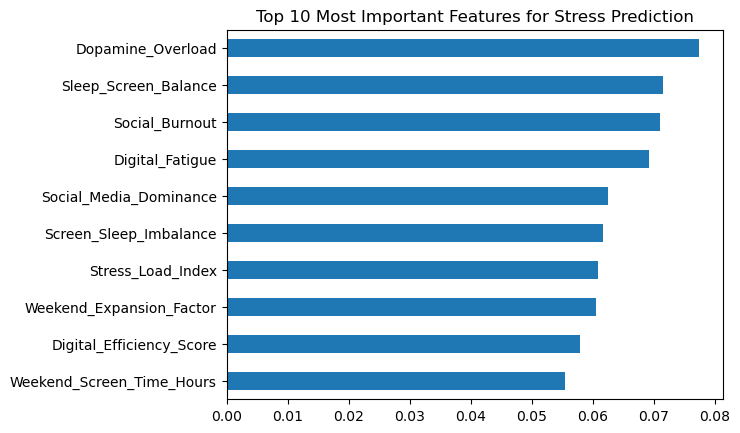

In [70]:
importance.head(10).plot(kind="barh")
plt.title("Top 10 Most Important Features for Stress Prediction")
plt.gca().invert_yaxis()
plt.show()